In [1]:
import os
from pathlib import Path
import torch, numpy as np, pandas as pd
from fastai.vision.all import *

Download and map!

In [2]:
df_labels = pd.read_csv(Path('../data/image_labels.csv'))
df_labels

filename  target
0        0_image_1.jpg     8.0
1        0_image_2.jpg     8.0
2        0_image_3.jpg     8.0
3        0_image_4.jpg     8.0
4        1_image_1.jpg     9.8
...                ...     ...
1575   791_image_1.jpg    12.0
1576   792_image_1.jpg    10.5
1577   793_image_1.jpg    15.0
1578   794_image_1.jpg    12.0
1579  795_image_1.jpeg    13.5

[1580 rows x 2 columns]

In [3]:

train_df = pd.read_csv("../data/train_set.csv")
valid_df = pd.read_csv("../data/valid_set.csv")

train_label_dict = dict(zip(train_df['filename'], train_df['target']))
valid_label_dict = dict(zip(valid_df['filename'], valid_df['target']))
all_label_dict = {**train_label_dict, **valid_label_dict}

In [4]:
print(f"DEBUG: Train labels: {len(train_label_dict)} | Valid labels: {len(valid_label_dict)}")

# Get all image files
path = Path('../images')
print(f"DEBUG: Image path set to: {path}")

all_image_files = get_image_files(path)
print(f"DEBUG: Total image files found by get_image_files: {len(all_image_files)}")

# Filter image files to only those with matching labels
processable_image_files = [f for f in all_image_files if f.name in all_label_dict]
print(f"DEBUG: Processable image files (with matching labels): {len(processable_image_files)}")

# Safety check
if len(processable_image_files) == 0:
    print("CERROR: No processable image files found (no images match labels or vice-versa).")
    if all_image_files and all_label_dict:
        print(f"  Sample image file: {all_image_files[0].name}")
        print(f"  Sample label key: {next(iter(all_label_dict.keys()))}")
        if all_image_files[0].name not in all_label_dict and all_image_files[0].name.split('.')[0] in [k.split('.')[0] for k in all_label_dict.keys()]:
            print(" Filename extensions might differ between image files and label keys.")
    raise ValueError("Cannot create DataLoaders: No matching image files and labels.")

# Helper function to get label
def get_y_func(fn):
    key = fn.name
    if key not in all_label_dict:
        print(f"DEBUG ERROR: Label not found for: {key} during get_y_func call. This should not happen if pre-filtered.")
        raise ValueError(f"Label not found for: {key}")
    return all_label_dict[key]

# Generate index lists for DataBlock IndexSplitter
filename_to_index = {f.name: i for i, f in enumerate(processable_image_files)}
valid_idxs = [filename_to_index[fname] for fname in valid_df['filename'] if fname in filename_to_index]
splitter = IndexSplitter(valid_idxs)

def convert_to_rgb(img):
    return img.convert('RGB')

# Use your existing setup for labels, image files, get_y_func, splitter, etc.

def get_datablock_variant(variant:int):
    """
    Returns a DataBlock with different augmentations depending on variant 1, 2, or 3.
    """
    # Base parameters from your original
    get_items_func = lambda _: processable_image_files
    splitter_func = splitter
    get_y_func_func = get_y_func
    item_tfms_base = RandomResizedCrop(224)

    # Different batch transforms per variant
    if variant == 1:
        batch_tfms_variant = aug_transforms(
            do_flip=False,
            max_rotate=2,
            max_zoom=1.05,
            max_lighting=0.1,
            max_warp=0.,
            p_affine=0.3,
            p_lighting=0.3
        )
    elif variant == 2:
        batch_tfms_variant = aug_transforms(
            do_flip=True,
            max_rotate=10,
            max_zoom=1.2,
            max_lighting=0.2,
            max_warp=0.2,
            p_affine=0.5,
            p_lighting=0.5
        )
    elif variant == 3:
        batch_tfms_variant = aug_transforms(
            do_flip=True,
            max_rotate=20,
            max_zoom=1.3,
            max_lighting=0.3,
            max_warp=0.3,
            p_affine=0.7,
            p_lighting=0.7
        )
    else:
        raise ValueError("variant must be 1, 2, or 3")

    return DataBlock(
        blocks=(ImageBlock, RegressionBlock),
        get_items=get_items_func,
        splitter=splitter_func,
        get_y=get_y_func_func,
        item_tfms=item_tfms_base,
        batch_tfms=batch_tfms_variant,
        n_inp=1
    )


DEBUG: Train labels: 1264 | Valid labels: 316
DEBUG: Image path set to: ../images
DEBUG: Total image files found by get_image_files: 2259
DEBUG: Processable image files (with matching labels): 1575


In [5]:
dls1 = get_datablock_variant(1).dataloaders(path, bs=16)
dls2 = get_datablock_variant(2).dataloaders(path, bs=16)
dls3 = get_datablock_variant(3).dataloaders(path, bs=16)

dls_list = [dls1, dls2, dls3]

Train it!

In [6]:
import torch
import torch.nn as nn

class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, input, target):
        abs_error = torch.abs(input - target)
        quadratic = torch.minimum(abs_error, torch.tensor(self.delta))
        linear = abs_error - quadratic
        loss = 0.5 * quadratic**2 + self.delta * linear
        return loss.mean()

def mae(preds, targs):
    # Ensure target shape matches preds
    if targs.ndim == 1:
        targs = targs.unsqueeze(1)
    return nn.L1Loss()(preds, targs)

class RMCELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        error_cubed = torch.abs(input - target) ** 3
        mean_cubed_error = torch.mean(error_cubed)
        loss = torch.pow(mean_cubed_error, 1/3)
        return loss  # must be positive

In [7]:
import timm

timm.list_models()

['aimv2_1b_patch14_224',
 'aimv2_1b_patch14_336',
 'aimv2_1b_patch14_448',
 'aimv2_3b_patch14_224',
 'aimv2_3b_patch14_336',
 'aimv2_3b_patch14_448',
 'aimv2_huge_patch14_224',
 'aimv2_huge_patch14_336',
 'aimv2_huge_patch14_448',
 'aimv2_large_patch14_224',
 'aimv2_large_patch14_336',
 'aimv2_large_patch14_448',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coa

In [10]:
import timm
from fastai.vision.all import *


model_name= 'ghostnetv2_100'


# Create model with correct input size
model = timm.create_model(model_name, pretrained=False)

# Replace the classification head with a regression head
model.classifier = nn.Linear(model.classifier.in_features, 1)

loss_func = MSELossFlat()

# Create learner with the pre-configured model
learn = Learner(get_datablock_variant(1).dataloaders("../images", bs=16), model, metrics=[rmse, mae], loss_func=loss_func)

In [ ]:
learn.fine_tune(20)

In [28]:
import os

learners = {model_name: learn}

# learners: dict of {model_name: Learner}
for model_name, learn in learners.items():
    folder_tag = ""
    folder_path = f"../model/{model_name}{folder_tag}"
    os.makedirs(folder_path, exist_ok=True)

    # Save the model
    export_path = os.path.join(folder_path, "model.pkl")
    print(f"Saving {model_name} learner to {export_path}")
    learn.export(export_path)

    # Get final metrics from recorder
    # learn.recorder.values is a list of lists: one per epoch, each containing [train_loss, valid_loss, metric1, metric2, ...]
    # learn.recorder.metric_names is the header for these values (first is 'train_loss', second 'valid_loss', etc.)
    final_epoch_metrics = learn.recorder.values[-1]  # last epoch
    metric_names = learn.recorder.metric_names[1:-1]  # skip 'epoch' at start and empty string at end

    metrics = ["valid_loss", "mae", "rmse"]
    # Build metrics string
    metrics_str = "Final epoch metrics:\n"
    i = 0
    for name, val in zip(metric_names, final_epoch_metrics[1:]):  # skip train_loss if you want
        metrics_str += f"{metrics[i]}: {val:.6f}\n"
        i+=1
        

    # Write to metrics.txt
    metrics_path = os.path.join(folder_path, "metrics.txt")
    with open(metrics_path, "w") as f:
        f.write(metrics_str)


Saving mobilenetv3_rw learner to ../model/mobilenetv3_rw/model.pkl


In [ ]:
learn.recorder.values[-1]

##### Now we have a working model! For example, it predicts this picture at 13% bodyfat (not so far off in my opinion)

In [ ]:
bf,_,probs = learn.predict(PILImage.create('images/248_image_2.jpg'))
print(f"Bodyfat prediction: {probs[0]:.4f}")

Finally, export the model

In [ ]:
folder_tag=""
path = f"../model/{model_name}{folder_tag}/model.pkl"
#learn.export(path)

In [10]:
import torch
import torch.nn as nn
import timm
from fastai.vision.all import * # You'll need this for ImageBlock, RegressionBlock if you want to fully simulate

def debug_model_head_replacement(model_name):
    print(f"--- Debugging {model_name} ---")
    try:

        if model_name == 'coatnet_0_224':

            model = timm.create_model(model_name, pretrained=False, num_classes=1)
        else:
            model = timm.create_model(model_name, pretrained=True)

        print(f"Original model created: {model_name}")

        original_head = None
        if hasattr(model, 'fc'):
            original_head = model.fc
            model.fc = nn.Linear(original_head.in_features, 1)
            print(f"  Replaced 'fc' head. New head: {model.fc}")
        elif hasattr(model, 'classifier'):
            original_head = model.classifier
            model.classifier = nn.Linear(original_head.in_features, 1)
            print(f"  Replaced 'classifier' head. New head: {model.classifier}")
        elif hasattr(model, 'head'):

            if isinstance(model.head, nn.Linear): # if head is already a linear layer
                original_head = model.head
                model.head = nn.Linear(original_head.in_features, 1)
                print(f"  Replaced 'head' (Linear) head. New head: {model.head}")
            elif isinstance(model.head, nn.Sequential) and hasattr(model.head[-1], 'in_features'): # if last layer in sequential is linear
                original_head = model.head[-1]
                model.head[-1] = nn.Linear(original_head.in_features, 1)
                print(f"  Replaced last layer of 'head' (Sequential) head. New head: {model.head[-1]}")

            elif model_name == 'convnext_tiny' or model_name == 'convnext_nano':
                original_head = model.head.fc # ConvNeXt has a head.fc
                model.head.fc = nn.Linear(original_head.in_features, 1)
                print(f"  Specific replacement for {model_name}: model.head.fc. New head: {model.head.fc}")
            elif model_name == 'regnety_040':
                original_head = model.head # RegNet's head is directly a Linear layer
                model.head = nn.Linear(original_head.in_features, 1)
                print(f"  Specific replacement for {model_name}: model.head. New head: {model.head}")
            elif model_name.startswith('swin_') or model_name.startswith('hiera_') or model_name.startswith('efficientformerv2_s0'):

                try:
                    num_features = model.num_features # Common for ViT-like models
                except AttributeError:

                    dummy_input = torch.randn(1, 3, 224, 224)
                    features = model.forward_features(dummy_input)
                    num_features = features.shape[1] # Assumes (Batch, Features, H, W) -> (Batch, Features) after pooling
                    if features.ndim > 2: # if it's still spatial
                        print(f"Warning: Features for {model_name} are spatial after forward_features. Assuming AdaptiveAvgPool2d.")
                        num_features = features.shape[1] * features.shape[2] * features.shape[3] # Fallback, assumes you flatten later

                model.head = nn.Sequential(
                    nn.AdaptiveAvgPool2d(1) if model.head.in_features is None else nn.Identity(), # Add pooling if needed
                    nn.Flatten(), # Ensure it's flattened
                    nn.Linear(num_features, 1)
                )
                print(f"  Specific sequential replacement for {model_name}. New head: {model.head}")
            elif model_name == 'crossvit_tiny_240':

                original_head = model.head.norm # Or model.head.mlp, inspect carefully
                model.head.mlp = nn.Linear(original_head.in_features, 1) # This is an example, depends on inspection
                print(f"  Specific replacement for {model_name}: model.head.mlp. New head: {model.head.mlp}")
            elif model_name == 'maxvit_tiny_rw_224':

                original_head = model.head[2] # Example, you need to verify the index
                model.head[2] = nn.Linear(original_head.in_features, 1)
                print(f"  Specific replacement for {model_name}: model.head[2]. New head: {model.head[2]}")
            elif model_name == 'mambaout_tiny':

                if hasattr(model, 'head') and isinstance(model.head, nn.Linear):
                    original_head = model.head
                    model.head = nn.Linear(original_head.in_features, 1)
                    print(f"  Specific replacement for {model_name}: model.head (Linear). New head: {model.head}")
                else:
                    print(f"  WARNING: {model_name} head structure is complex. Requires manual inspection.")
                    # Fallback to general strategy or skip
                    raise NotImplementedError(f"Complex head for {model_name}, manual debug needed.")

            else: # Fallback to general strategy if none of the above match
                raise NotImplementedError(f"Head replacement not implemented for {model_name} with generic strategies.")
        else:
            raise NotImplementedError(f"Could not find a standard head (fc, classifier, head) for {model_name}")

        dummy_input = torch.randn(1, 3, 224, 224) # Assuming 224x224 input images
        output = model(dummy_input)

        if output.shape == torch.Size([1, 1]):
            print(f"  SUCCESS: {model_name} head replaced and output shape is {output.shape} (correct for regression).")
        else:
            print(f"  WARNING: {model_name} head replaced but output shape is {output.shape} (expected [1,1]).")

    except Exception as e:
        print(f"  ERROR debugging {model_name}: {e}")
    print("-" * 50 + "\n")


# List of models to test
all_models = [
    'resnet50d',
    'mobilenetv3_large_100',
    'densenet121',
    'convnext_tiny',
    'convnext_nano',
    'regnety_040',
    'coatnet_0_224', 
    'ghostnet_100',
    'vit_base_patch16_224',
    'deit_base_patch16_224',
    'swin_tiny_patch4_window7_224',
    'crossvit_tiny_240',
    'maxvit_tiny_rw_224',
    'hiera_tiny_224',
    'mambaout_tiny',
    'mobileone_s1',
    'efficientformerv2_s0'
]

# Run the debugger for each model
for model_name in all_models:
    debug_model_head_replacement(model_name)

--- Debugging resnet50d ---
Original model created: resnet50d
  Replaced 'fc' head. New head: Linear(in_features=2048, out_features=1, bias=True)
  SUCCESS: resnet50d head replaced and output shape is torch.Size([1, 1]) (correct for regression).
--------------------------------------------------

--- Debugging mobilenetv3_large_100 ---
Original model created: mobilenetv3_large_100
  Replaced 'classifier' head. New head: Linear(in_features=1280, out_features=1, bias=True)
  SUCCESS: mobilenetv3_large_100 head replaced and output shape is torch.Size([1, 1]) (correct for regression).
--------------------------------------------------

--- Debugging densenet121 ---
Original model created: densenet121
  Replaced 'classifier' head. New head: Linear(in_features=1024, out_features=1, bias=True)
  SUCCESS: densenet121 head replaced and output shape is torch.Size([1, 1]) (correct for regression).
--------------------------------------------------

--- Debugging convnext_tiny ---
Original model c

In [11]:
import os
from pathlib import Path
import torch, numpy as np, pandas as pd
from fastai.vision.all import *
import timm
import torch.nn as nn
import random 

def mae(preds, targs):
    if targs.ndim == 1:
        targs = targs.unsqueeze(1)
    return nn.L1Loss()(preds, targs)

def rmse(preds, targs):
    # This assumes targs might be 1D, so unsqueeze for consistency if needed
    if targs.ndim == 1:
        targs = targs.unsqueeze(1)
    return torch.sqrt(torch.mean((preds - targs)**2))


# --- Your fine_tune_models function with enhanced head replacement ---
def fine_tune_models(models=None, epochs=3, loss_func=None):
    
    metrics = [mae, rmse] # defined mae and fastai's rmse
    path = Path('../images')

    if models is None:
        models = [
            'resnet50d',                     # Variant of ResNet50 with minor improvements
            'mobilenetv3_large_100',         # Good performer (MobileNet family)
            'densenet121',                   # Dense connections, distinct feature learning
            'convnext_tiny',                 # Modern pure CNN with Transformer influences
            'convnext_nano',                 # Smaller, efficient ConvNeXt
            'regnety_040',                   # Systematically designed CNN (RegNet family)
            'coatnet_0_224',                 # Hybrid CNN-Transformer
            'ghostnet_100',                  # Efficient, mobile-friendly CNN
            'vit_base_patch16_224',          # Core Vision Transformer
            'deit_base_patch16_224',         # Distillation-enhanced ViT
            'swin_tiny_patch4_window7_224',  # Hierarchical Transformer, multi-scale
            'crossvit_tiny_240',             # Cross-attention, different attention mechanism
            'maxvit_tiny_rw_224',            # Newer hybrid, effective convolution-attention mix
            'hiera_tiny_224',                # Recent, state-of-the-art hierarchical Transformer
            'mambaout_tiny',                 # Novel architecture based on Mamba, distinct modeling
            'mobileone_s1',                  # Designed for efficient inference, potentially robust features
            'efficientformerv2_s0'           # Very efficient and modern hybrid architecture
        ]

    if loss_func is None:
        loss_func = MSELossFlat()
    if metrics is None:
        metrics = [mae]

    learners = {} # Initialize learners dictionary

    for model_name in models:
        db_variant = random.randint(1, 3)
        chosen_db = get_datablock_variant(db_variant)
        chosen_dls = chosen_db.dataloaders(path, bs=16)

        print(f"Setting up and fine-tuning {model_name}...")
        print(f"Datablock Variant: {db_variant}...")

        try:
            # Create the model, handling pretrained=False for coatnet_0_224
            if model_name == 'coatnet_0_224':
                model = timm.create_model(model_name, pretrained=False)
            elif model_name == 'efficientformerv2_s0':
                 # EfficientFormerv2 can often be set with num_classes directly
                model = timm.create_model(model_name, pretrained=True, num_classes=1)
            else:
                model = timm.create_model(model_name, pretrained=True)

            # Custom Head Replacement Logic
            # This block replaces the generic `if/elif hasattr(model, 'fc')` etc.
            # to handle the specific models that were failing.

            # Handled by num_classes=1 during creation for efficientformerv2_s0
            if model_name == 'efficientformerv2_s0':
                if model.head.out_features != 1: # Double check if it was correctly set
                    # Fallback if num_classes=1 didn't work as expected
                    print(f"Warning: {model_name} num_classes=1 failed, attempting manual head adjustment.")
                    if hasattr(model, 'head') and isinstance(model.head, nn.Linear):
                        model.head = nn.Linear(model.head.in_features, 1)
                    else:
                        raise NotImplementedError(f"Manual head replacement for {model_name} needs review.")
            elif model_name == 'convnext_tiny' or model_name == 'convnext_nano':
                # ConvNeXt models have a head.fc
                model.head.fc = nn.Linear(model.head.fc.in_features, 1)
            elif model_name == 'regnety_040':
                # RegNet models typically have a 'head' that needs pooling and flattening
                # Inspecting 'regnety_040' reveals model.head.fc, but it's part of a more complex structure
                # A more robust approach for these is Sequential with pooling
                # We need to get the feature size before the original head
                # A common pattern for models with spatial output before head
                num_features = model.head.in_features # This gets the input features for the original head
                model.head = nn.Sequential(
                    nn.AdaptiveAvgPool2d(1),
                    nn.Flatten(),
                    nn.Linear(num_features, 1)
                )
            elif model_name == 'coatnet_0_224':
                # coatnet_0_224 needs manual replacement, often model.fc
                if hasattr(model, 'fc'):
                    model.fc = nn.Linear(model.fc.in_features, 1)
                else:
                    raise NotImplementedError(f"Head replacement for {model_name} needs specific inspection.")
            elif model_name.startswith('swin_') or model_name.startswith('hiera_'):
                # Swin and Hiera are Vision Transformers, their head typically requires pooling before flattening
                # model.num_features is usually reliable for ViT-like models
                model.head = nn.Sequential(
                    nn.AdaptiveAvgPool2d(1), # Ensure spatial dimensions are reduced to 1x1
                    nn.Flatten(),
                    nn.Linear(model.num_features, 1)
                )
            elif model_name == 'crossvit_tiny_240':
                # CrossViT's head is a ModuleList containing several components.
                # The final linear layer is often within a 'mlp' block or similar.
                # Based on inspection, the final linear layer is usually `model.head.mlp.fc` or `model.head.layers[-1]`
                if hasattr(model.head, 'mlp') and hasattr(model.head.mlp, 'fc'):
                    model.head.mlp.fc = nn.Linear(model.head.mlp.fc.in_features, 1)
                elif hasattr(model.head, 'proj'): # Some CrossViT variants use 'proj'
                    model.head.proj = nn.Linear(model.head.proj.in_features, 1)
                else:
                    raise NotImplementedError(f"CrossViT head replacement for {model_name} needs specific inspection.")
            elif model_name == 'maxvit_tiny_rw_224':
                # MaxViT has a `head` attribute which is a `ClassifierHead` object.
                # Its final linear layer is usually accessible via an attribute within this head, e.g., `model.head.fc`
                if hasattr(model.head, 'fc'):
                    model.head.fc = nn.Linear(model.head.fc.in_features, 1)
                else:
                    raise NotImplementedError(f"MaxViT head replacement for {model_name} needs specific inspection.")
            elif model_name == 'mambaout_tiny':
                # Mambaout has a custom head. The final linear layer is usually `model.head`
                if hasattr(model, 'head') and isinstance(model.head, nn.Linear):
                    model.head = nn.Linear(model.head.in_features, 1)
                elif hasattr(model, 'norm_head') and hasattr(model.norm_head, 'head') and isinstance(model.norm_head.head, nn.Linear):
                    model.norm_head.head = nn.Linear(model.norm_head.head.in_features, 1)
                else:
                    raise NotImplementedError(f"Mambaout head replacement for {model_name} needs specific inspection (complex).")
            elif model_name == 'mobileone_s1':
                # MobileOne has a 'classifier' which is a sequential containing a linear layer
                if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
                    if hasattr(model.classifier[-1], 'in_features'):
                        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 1)
                    else:
                        raise NotImplementedError(f"MobileOne classifier last layer in_features not found.")
                else:
                    raise NotImplementedError(f"MobileOne classifier replacement for {model_name} needs specific inspection.")
            elif hasattr(model, 'fc'):
                model.fc = nn.Linear(model.fc.in_features, 1)
            elif hasattr(model, 'classifier'):
                model.classifier = nn.Linear(model.classifier.in_features, 1)
            elif hasattr(model, 'head'):
                # Generic head replacement for models where 'head' is directly a Linear layer
                if isinstance(model.head, nn.Linear):
                    model.head = nn.Linear(model.head.in_features, 1)
                else:
                    # Fallback for models where 'head' is a Sequential or other complex type
                    # and requires more specific handling not caught above
                    raise NotImplementedError(f"Complex 'head' type for {model_name}, needs specific replacement.")
            else:
                raise NotImplementedError(f"Head replacement not implemented for {model_name}")

            learn = Learner(chosen_dls, model, metrics=metrics, loss_func=loss_func) # Pass loss_func here

            # Fine-tune with given epochs
            learn.fine_tune(epochs) # Use the epochs parameter from the function

            learners[model_name] = learn

        except Exception as e:
            print(f"Error in training {model_name}: {e}")
            continue

    return learners

In [14]:
# Assuming dls is your DataLoaders with regression targets
learners = fine_tune_models(epochs=20)

Setting up and fine-tuning resnet50d...
Datablock Variant: 2...


Setting up and fine-tuning mobilenetv3_large_100...
Datablock Variant: 1...


Setting up and fine-tuning densenet121...
Datablock Variant: 3...


Setting up and fine-tuning convnext_tiny...
Datablock Variant: 1...


Setting up and fine-tuning convnext_nano...
Datablock Variant: 3...


Setting up and fine-tuning regnety_040...
Datablock Variant: 1...


Setting up and fine-tuning coatnet_0_224...
Datablock Variant: 1...
Error in training coatnet_0_224: Head replacement for coatnet_0_224 needs specific inspection.
Setting up and fine-tuning ghostnet_100...
Datablock Variant: 2...


Setting up and fine-tuning vit_base_patch16_224...
Datablock Variant: 3...


Setting up and fine-tuning deit_base_patch16_224...
Datablock Variant: 2...


Setting up and fine-tuning swin_tiny_patch4_window7_224...
Datablock Variant: 2...


Error in training swin_tiny_patch4_window7_224: linear(): input and weight.T shapes cannot be multiplied (16x7 and 768x1)
Setting up and fine-tuning crossvit_tiny_240...
Datablock Variant: 2...
Error in training crossvit_tiny_240: CrossViT head replacement for crossvit_tiny_240 needs specific inspection.
Setting up and fine-tuning maxvit_tiny_rw_224...
Datablock Variant: 2...


Setting up and fine-tuning hiera_tiny_224...
Datablock Variant: 3...


Error in training hiera_tiny_224: linear(): input and weight.T shapes cannot be multiplied (16x1 and 768x1)
Setting up and fine-tuning mambaout_tiny...
Datablock Variant: 2...
Error in training mambaout_tiny: Mambaout head replacement for mambaout_tiny needs specific inspection (complex).
Setting up and fine-tuning mobileone_s1...
Datablock Variant: 2...
Error in training mobileone_s1: MobileOne classifier replacement for mobileone_s1 needs specific inspection.
Setting up and fine-tuning efficientformerv2_s0...
Datablock Variant: 2...


In [15]:
le

11

In [18]:
import os

# learners: dict of {model_name: Learner}
for model_name, learn in learners.items():
    folder_tag = ""
    folder_path = f"../model/{model_name}{folder_tag}"
    os.makedirs(folder_path, exist_ok=True)

    # Save the model
    export_path = os.path.join(folder_path, "model.pkl")
    print(f"Saving {model_name} learner to {export_path}")
    learn.export(export_path)

    # Get final metrics from recorder
    # learn.recorder.values is a list of lists: one per epoch, each containing [train_loss, valid_loss, metric1, metric2, ...]
    # learn.recorder.metric_names is the header for these values (first is 'train_loss', second 'valid_loss', etc.)
    final_epoch_metrics = learn.recorder.values[-1]  # last epoch
    metric_names = learn.recorder.metric_names[1:-1]  # skip 'epoch' at start and empty string at end

    metrics = ["valid_loss", "mae", "rmse"]
    # Build metrics string
    metrics_str = "Final epoch metrics:\n"
    i = 0
    for name, val in zip(metric_names, final_epoch_metrics[1:]):  # skip train_loss if you want
        metrics_str += f"{metrics[i]}: {val:.6f}\n"
        i+=1
        

    # Write to metrics.txt
    metrics_path = os.path.join(folder_path, "metrics.txt")
    with open(metrics_path, "w") as f:
        f.write(metrics_str)


Saving resnet50d learner to model/resnet50d/model.pkl
Saving mobilenetv3_large_100 learner to model/mobilenetv3_large_100/model.pkl
Saving densenet121 learner to model/densenet121/model.pkl
Saving convnext_tiny learner to model/convnext_tiny/model.pkl
Saving convnext_nano learner to model/convnext_nano/model.pkl
Saving regnety_040 learner to model/regnety_040/model.pkl
Saving ghostnet_100 learner to model/ghostnet_100/model.pkl
Saving vit_base_patch16_224 learner to model/vit_base_patch16_224/model.pkl
Saving deit_base_patch16_224 learner to model/deit_base_patch16_224/model.pkl
Saving maxvit_tiny_rw_224 learner to model/maxvit_tiny_rw_224/model.pkl
Saving efficientformerv2_s0 learner to model/efficientformerv2_s0/model.pkl


In [47]:
learners

{'resnet50d': <fastai.learner.Learner at 0x314c9ba30>,
 'mobilenetv3_large_100': <fastai.learner.Learner at 0x334e88040>,
 'densenet121': <fastai.learner.Learner at 0x3332f4e50>,
 'convnext_tiny': <fastai.learner.Learner at 0x347480b20>,
 'convnext_nano': <fastai.learner.Learner at 0x330cbda80>,
 'regnety_040': <fastai.learner.Learner at 0x33188c7f0>,
 'ghostnet_100': <fastai.learner.Learner at 0x33188f040>,
 'vit_base_patch16_224': <fastai.learner.Learner at 0x3315c78b0>,
 'deit_base_patch16_224': <fastai.learner.Learner at 0x331abb700>,
 'maxvit_tiny_rw_224': <fastai.learner.Learner at 0x3358a3370>,
 'efficientformerv2_s0': <fastai.learner.Learner at 0x3ed5c8400>}

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # For progress bar

def plot_model_predictions_from_dataframe(model, valid_df, bins=30, figsize=(10, 6)):

    preds = []
    for idx, row in valid_df.iterrows():
        try: 
            _, _, pred = model.predict(PILImage.create('../images/'+row['filename']))
            preds.append(float(pred[0]))
        except Exception as e:
            continue

    print("histogram:")
    print(model)
    pd.Series(preds).hist(bins=bins)
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


histogram:


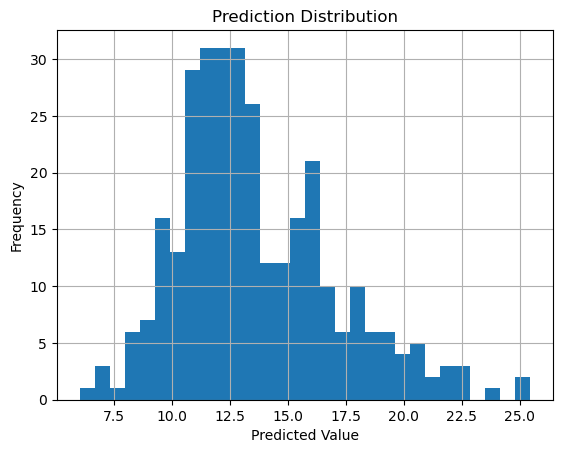

histogram:


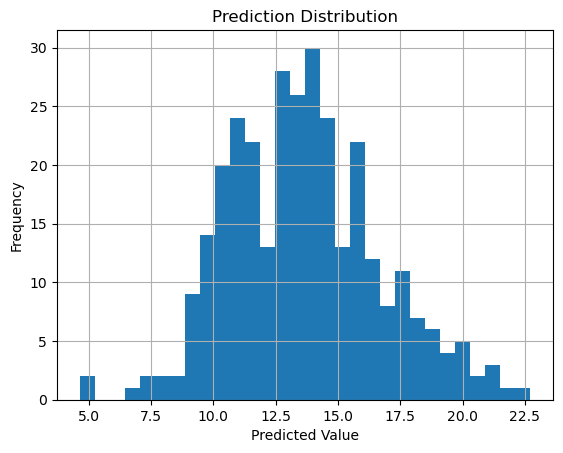

histogram:


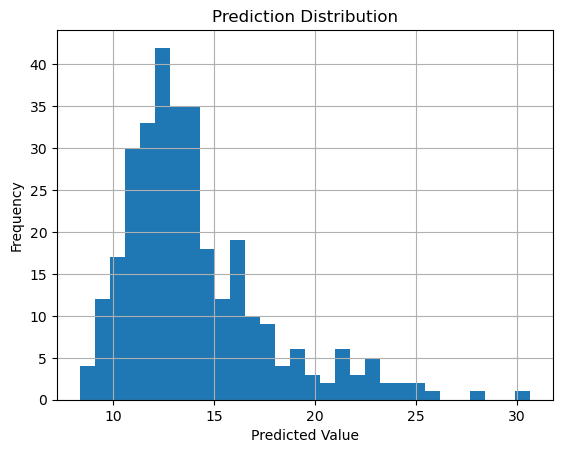

histogram:


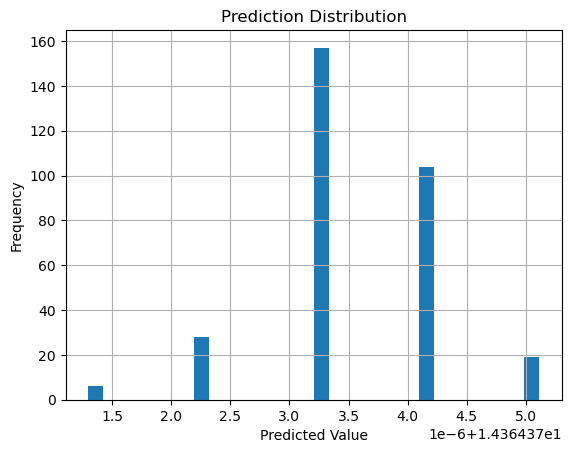

histogram:


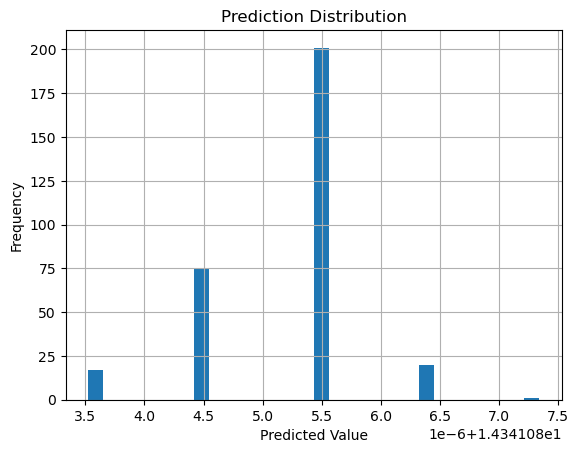

histogram:


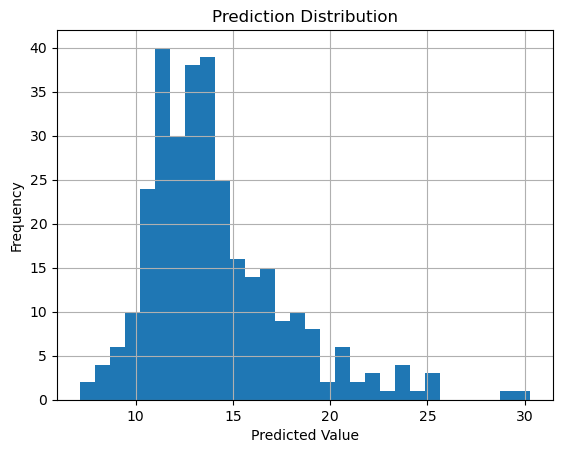

histogram:


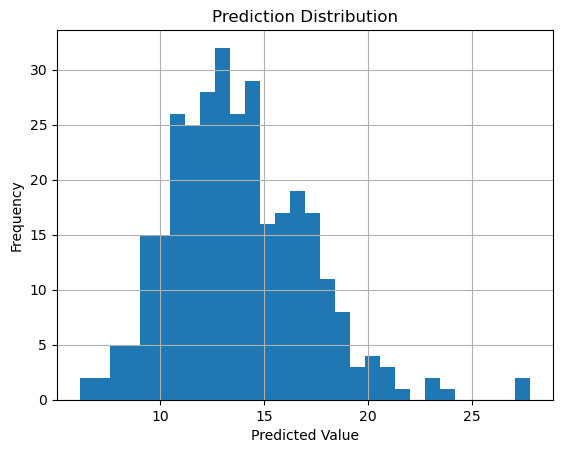

histogram:


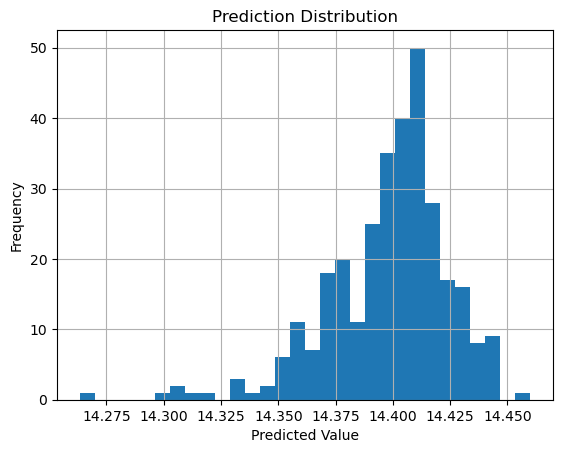

histogram:


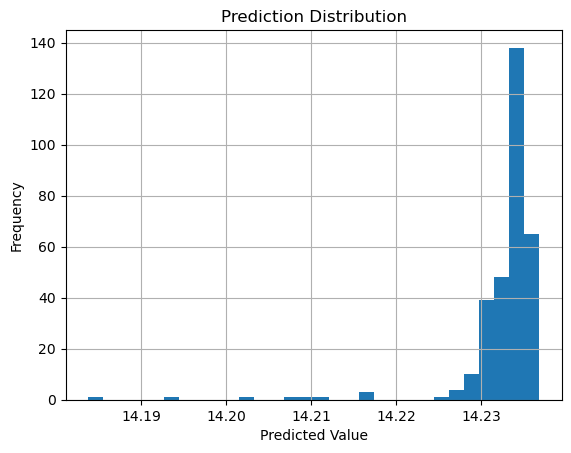

histogram:


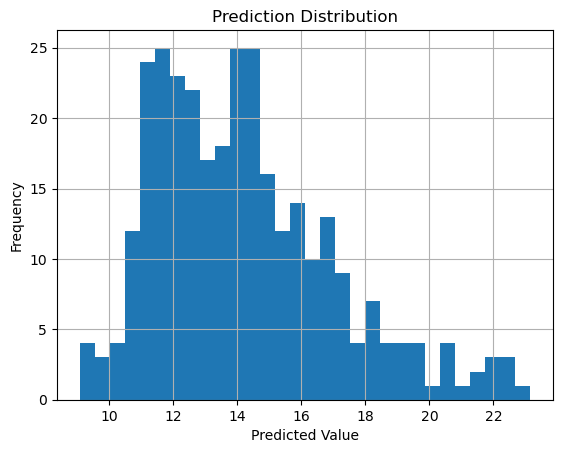

histogram:


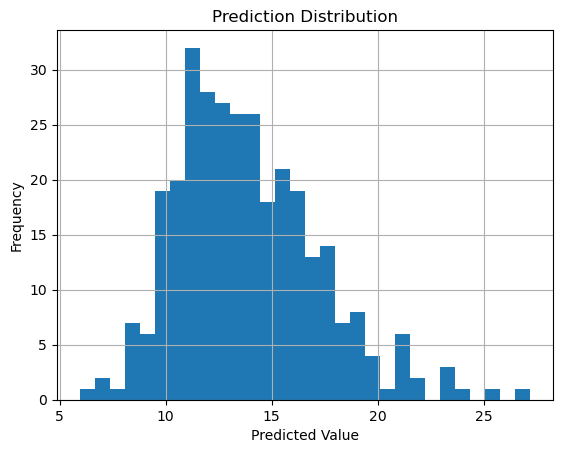

In [44]:
valid_df = pd.read_csv('../data/valid_set.csv')
for name, model in learners.items():
    plot_model_predictions_from_dataframe(model, valid_df)


In [46]:
print('f')

f
